# Importation des packages

In [1]:
import os

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd

In [2]:
from tensorflow.keras.applications import ResNet50

# Définition de certains hyperparamètres du modèle

In [3]:
NUM_CLASSE=2
IMAGE_SIZE=128
BATCH_SIZE = 128

# Construction du réseau avec les poids entrainé avec Imagenet

In [4]:
def build_resnet():
    model= ResNet50(include_top=False,weights= 'imagenet')
    return model

In [5]:
new_model = build_resnet()

In [6]:
new_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

# Réentrainement des poids du réseau

In [7]:
new_model.trainable = True 

# Changement de la derniere couche du réseau pour qu'elle s'adapte au nombre de classe que nous avons

In [8]:
avg = keras.layers.GlobalAveragePooling2D()(new_model.output)

In [9]:
output = keras.layers.Dense(NUM_CLASSE, activation="softmax")(avg)

In [10]:
model_transfer_learning = keras.Model(inputs=new_model.input, outputs=output)

# Compilation du modèle

In [11]:
METRICS = ["accuracy"]
    
model_transfer_learning.compile(
        optimizer='adam',
        loss= tf.losses.SparseCategoricalCrossentropy(),
        metrics=METRICS
)

# Préparation des données d'entrainement et de validation

In [ ]:
FOLDER = "Donnee_DP_réduite"
# create generator
datagen = ImageDataGenerator(rescale=1./255)

# prepare an iterators for each dataset
train = datagen.flow_from_directory(os.path.join(FOLDER,'train'), target_size=(IMAGE_SIZE, IMAGE_SIZE), class_mode="sparse", color_mode="rgb", batch_size=BATCH_SIZE)
val = datagen.flow_from_directory(os.path.join(FOLDER,'val'), target_size=(IMAGE_SIZE, IMAGE_SIZE), class_mode="sparse",color_mode="rgb", batch_size=BATCH_SIZE)
# confirm the iterator works
batchX, batchy = train.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

# Learning Rate Schedules et sauvegarde du modéle

Les learning rate schedules visent à ajuster le taux d'apprentissage pendant la formation en réduisant le taux d'apprentissage selon un schedule prédéfini.

In [14]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(FOLDER+"_imagenet_TL_model_freeze.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)

# Entrainement du modèle après transfer learning

In [15]:
history = model_transfer_learning.fit(
    train,
    validation_data=val,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=100
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 18 steps, validate for 3 steps
Epoch 1/100
18/18 [==============================] - 30s 2s/step - loss: 3.0537 - accuracy: 0.5644 - val_loss: 36865900667670450176.0000 - val_accuracy: 0.5579
Epoch 2/100
18/18 [==============================] - 21s 1s/step - loss: 0.8663 - accuracy: 0.5600 - val_loss: 1600736548181.3333 - val_accuracy: 0.5579
Epoch 3/100
18/18 [==============================] - 22s 1s/step - loss: 0.6960 - accuracy: 0.5452 - val_loss: 4559626.5833 - val_accuracy: 0.5579
Epoch 4/100
18/18 [==============================] - 22s 1s/step - loss: 0.7463 - accuracy: 0.5666 - val_loss: 1072658.1458 - val_accuracy: 0.4421
Epoch 5/100
18/18 [==============================] - 22s 1s/step - loss: 0.6870 - accuracy: 0.6085 - val_loss: 21493.6016 - val_accuracy: 0.4421
Epoch 6/100
18/18 [==============================] - 22s 1s/step - loss: 0.6777 - accuracy: 0.6198 - val_loss: 26.7173 - val_accuracy: 0.4421
Epoch 7/100
18/

# Affichage des résultats pour images d'entrainement et de validation

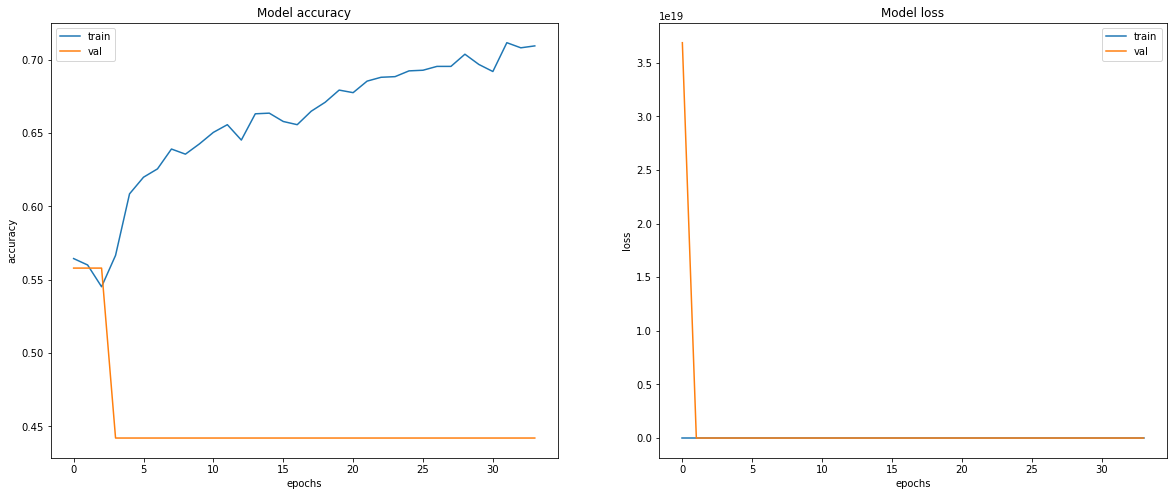

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# Préparation des images de test

In [17]:
datagen_test = ImageDataGenerator(rescale=1./255)

test = datagen_test.flow_from_directory(os.path.join(FOLDER,'test'), target_size=(IMAGE_SIZE, IMAGE_SIZE), class_mode="sparse",color_mode="rgb", batch_size=BATCH_SIZE)

Found 287 images belonging to 2 classes.


In [ ]:
# Evaluation du modèle à l'aide des données test

In [18]:
_ = model_transfer_learning.evaluate(test)

  ...
    to  
  ['...']
3/3 [==============================] - 3s 1s/step - loss: 0.7052 - accuracy: 0.4425
